In [100]:
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%aimport src.enthalpy_flowband_model
%autoreload 1
from src.enthalpy_flowband_model import EnthalpyFlowband

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def MH_surface(xs):
    a = -1 / 140625
    b = 7 / 75
    c = 300
    
    return a * xs**2 + b * xs + c

def MH_velocity(xs, zs, surface):
    a = -7 / 2812500
    b = 14 / 375
    c = 10
    decay = 0.6
    shear_ratio = 1 - decay
    fn_x = a * xs**2 + b * xs + c
    fn_z = (1 - decay) * (zs / surface) + decay
    
    return fn_x * fn_z * 3.14e-8

def MH_temperature(t):
    a = 16
    f = 1 / 3.14e7
    b = 20
    
    return a * np.sin(2 * np.pi * f * t) + b

In [186]:
air_temp = 273
temperature_boundary = np.array([air_temp, 273, air_temp, air_temp])
porosity_boundary = np.array([0.0, 4.0, 0.0, 0.0])

In [22]:
ef = EnthalpyFlowband(500, 500, 30, 1.5, 268.0, MH_surface, MH_velocity, temperature_boundary, porosity_boundary)

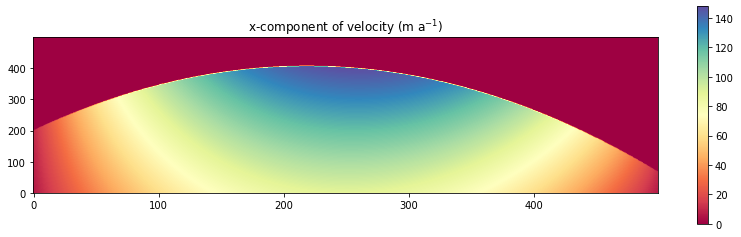

In [23]:
to_plot = ef.in_glacier * ef.velocity_x * 3.14e7

fig, ax = plt.subplots(figsize = (14, 4))

im = ax.imshow(to_plot, aspect = 0.25, cmap = 'Spectral')
plt.gca().invert_yaxis()
plt.colorbar(im)
plt.title('x-component of velocity (m a$^{-1}$)')
plt.show()

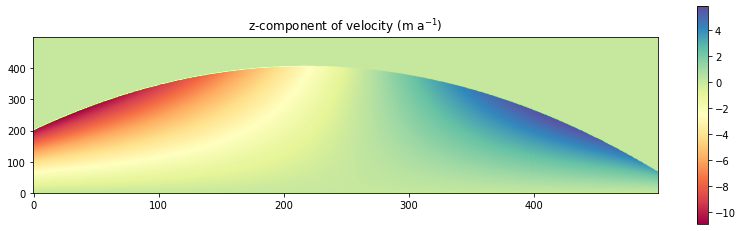

In [24]:
to_plot = ef.in_glacier * ef.velocity_z * 3.14e7

fig, ax = plt.subplots(figsize = (14, 4))

im = ax.imshow(to_plot, aspect = 0.25, cmap = 'Spectral')
plt.gca().invert_yaxis()
plt.colorbar(im)
plt.title('z-component of velocity (m a$^{-1}$)')
plt.show()

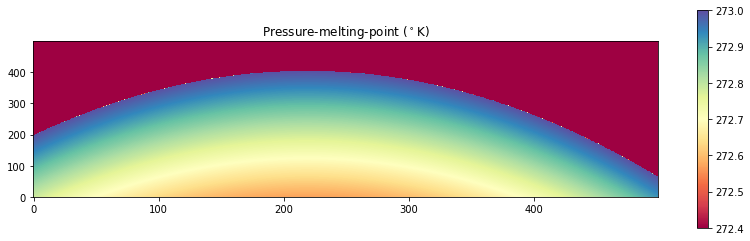

In [25]:
to_plot = ef.in_glacier * ef.melt_point

fig, ax = plt.subplots(figsize = (14, 4))

im = ax.imshow(to_plot, aspect = 0.25, cmap = 'Spectral', vmin = 272.4, vmax = 273)
plt.gca().invert_yaxis()
plt.colorbar(im)
plt.title('Pressure-melting-point ($^\circ$K)')
plt.show()

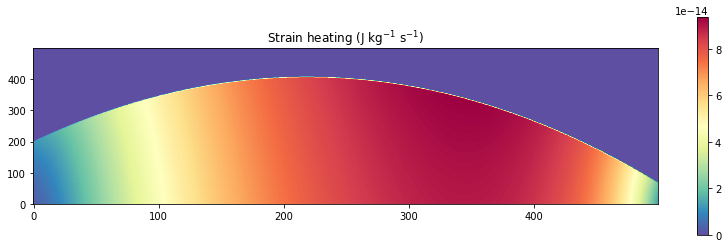

In [26]:
to_plot = ef.in_glacier * ef.internal_energy

fig, ax = plt.subplots(figsize = (14, 4))

im = ax.imshow(to_plot, aspect = 0.25, cmap = 'Spectral_r')
plt.gca().invert_yaxis()
plt.colorbar(im)
plt.title('Strain heating (J kg$^{-1}$ s$^{-1}$)')
plt.show()

## Test: isolate the source term
$
\frac{\partial h}{\partial t} = \tau_{ij}\dot{\epsilon}_{ij}
$

In [130]:
ef = EnthalpyFlowband(500, 500, 30, 1.5, 268.0, MH_surface, MH_velocity, temperature_boundary, porosity_boundary)

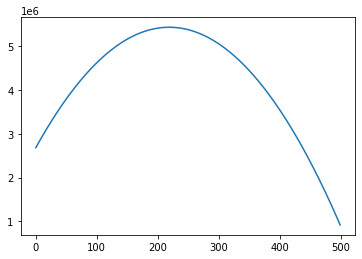

In [116]:
plt.plot(ef.effective_pressure[1, :])
plt.show()

In [150]:
nt = 1000
dt = 1e6 * 3.14e7
time_elapsed = 0.0

for t in range(nt):
    ef.enthalpy += ef.internal_energy * dt * ef.in_glacier
    
    time_elapsed += dt
    
    if t % int(nt / 10) == 0:
        print('Completed ' + str(t) + ' time steps.')
        
    if np.count_nonzero(ef.porosity) > 0:
        break
        
print('Time elapsed: ' + str(np.round(time_elapsed / 3.14e7, 2)) + ' years.')

Completed 0 time steps.
Completed 100 time steps.
Completed 200 time steps.
Completed 300 time steps.
Completed 400 time steps.
Completed 500 time steps.
Completed 600 time steps.
Completed 700 time steps.
Completed 800 time steps.
Completed 900 time steps.
Time elapsed: 1000000000.0 years.


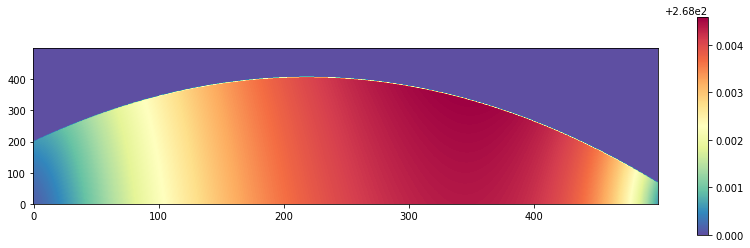

In [152]:
ef.update_temperature()
ef.update_porosity()
ef.partition_domain()

to_plot = ef.temperature

fig, ax = plt.subplots(figsize = (14, 4))

im = ax.imshow(to_plot, aspect = 0.25, cmap = 'Spectral_r')
plt.gca().invert_yaxis()
plt.colorbar(im)
plt.show()

Conclusion: no amount of strain heating __in this velocity configuration__ will raise the temperature of this glacier by even 1 degree. 

## Test: add diffusion
$
\frac{\partial h}{\partial t} = k\frac{\partial^2 T}{\partial z^2} + \tau_{ij}\dot{\epsilon}_{ij}
$

In [167]:
ef = EnthalpyFlowband(500, 500, 30, 1.5, 268.0, MH_surface, MH_velocity, temperature_boundary, porosity_boundary)

In [157]:
ef.compute_diffusion()

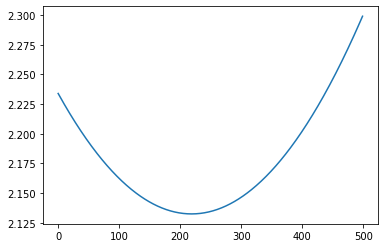

In [158]:
plt.plot(ef.diffusion[1, :])
plt.show()

In [197]:
ef = EnthalpyFlowband(500, 500, 30, 1.5, 268.0, MH_surface, MH_velocity, temperature_boundary, porosity_boundary, start_temperate = True)

nt = 10
dt = 1e3
time_elapsed = 0.0

for t in range(nt):
    ef.compute_diffusion()
    ef.enthalpy += (ef.internal_energy + ef.diffusion) * dt * ef.in_glacier
    
    ef.update_temperature()
    ef.update_porosity()
    ef.update_pressure()
    ef.partition_domain()
    
    time_elapsed += dt
    
    if t % int(nt / 10) == 0:
        print('Completed ' + str(t) + ' time steps.')
                
print('Time elapsed: ' + str(np.round(time_elapsed / 3.14e7, 2)) + ' years.')

Completed 0 time steps.
Completed 1 time steps.
Completed 2 time steps.
Completed 3 time steps.
Completed 4 time steps.
Completed 5 time steps.
Completed 6 time steps.
Completed 7 time steps.
Completed 8 time steps.
Completed 9 time steps.
Time elapsed: 0.0 years.


/home/egp/repos/basal-ice-facies/enthalpy/src/enthalpy_flowband_model.py:131: RuntimeWarning: invalid value encountered in true_divide
  self.surface = self.surface_function(self.xgrid)


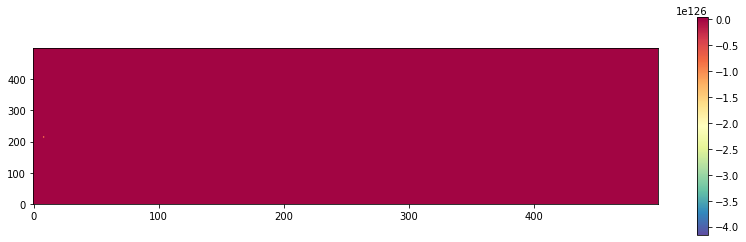

In [206]:
to_plot = ef.effective_pressure

fig, ax = plt.subplots(figsize = (14, 4))

im = ax.imshow(to_plot, aspect = 0.25, cmap = 'Spectral_r')
plt.gca().invert_yaxis()
plt.colorbar(im)
plt.show()